In [64]:
import networkx
import pandas as pd
import seaborn as sns

In [115]:
# Read in by-country file
df = pd.read_csv("../data/all-weeks-countries.tsv", sep='\t')
df.week = pd.to_datetime(df.week)
df.loc[:, 'item_title'] = df.apply(lambda x: x.season_title if type(x.season_title)!=float else x.show_title, axis=1)

In [21]:
# Top line descriptive stats
unique_values = df.nunique()
by_type = df.groupby('category').nunique()
print(f"""
Countries: {unique_values.country_name}
Weeks: {unique_values.week}
Items: {unique_values.show_title}
    {round(by_type.iloc[0].show_title / unique_values.show_title * 100, 1)}% movies
    {round(by_type.iloc[1].show_title / unique_values.show_title * 100, 1)}% TV shows
""")


Countries: 94
Weeks: 36
Items: 2355
    76.0% movies
    24.4% TV shows



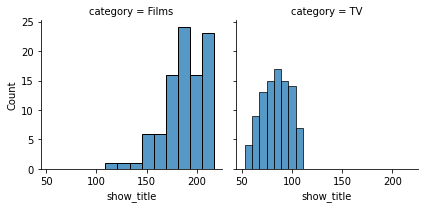

In [118]:
# Distribution of item count by country
items_by_country = df.groupby(['country_name', 'category']).nunique().show_title.reset_index()
g = sns.FacetGrid(items_by_country, col='category')
g.map(sns.histplot, 'show_title')

<AxesSubplot:>

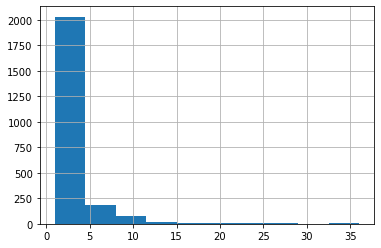

In [37]:
# Cumulative week distribution across countries
df.groupby('show_title').cumulative_weeks_in_top_10.max().hist()

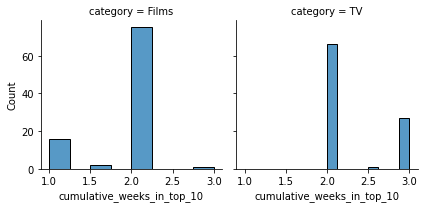

In [119]:
# Any variation in staying power by item type/country? (median cumulative weeks)
weeks_by_country_item = df.groupby(['country_name', 'item_title']).cumulative_weeks_in_top_10.max().reset_index()
weeks_by_country_item = weeks_by_country_item.set_index('item_title').join(df[['item_title', 'category']].drop_duplicates().set_index('item_title'))
mean_presence_by_country = weeks_by_country_item.groupby(['country_name', 'category']).median().reset_index()
g = sns.FacetGrid(mean_presence_by_country, col='category')
g.map(sns.histplot, 'cumulative_weeks_in_top_10')

<AxesSubplot:>

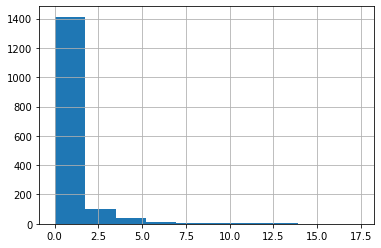

In [120]:
# Any variation in staying power by country at the item level?
variation_by_country = weeks_by_country_item.groupby(level=0).agg({'cumulative_weeks_in_top_10': ['count', 'std']})
variation_by_country.columns  = variation_by_country.columns.get_level_values(1)
variation_by_country[variation_by_country['count']>1]['std'].hist()

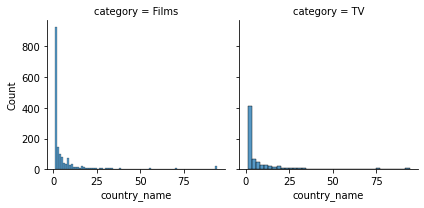

In [127]:
# Number of countries by item
countries_per_item = df.groupby(['category', 'item_title']).nunique().country_name.reset_index()
g = sns.FacetGrid(countries_per_item, col='category')
g.map(sns.histplot, 'country_name')

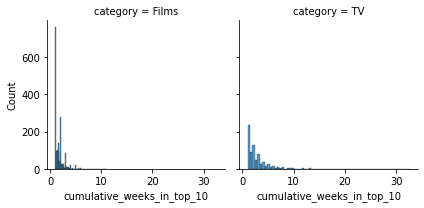

In [136]:
# Tenure distribution
mean_tenures = df.groupby(['category', 'item_title', 'country_name']).cumulative_weeks_in_top_10.max().groupby(level=[0, 1]).mean().reset_index()
g = sns.FacetGrid(mean_tenures, col='category')
g.map(sns.histplot, 'cumulative_weeks_in_top_10')

In [107]:
# Rank occupants


,country_name,country_iso2,week,category,weekly_rank,show_title,season_title,cumulative_weeks_in_top_10
32919,Lithuania,LT,2021-09-12,TV,10,Friends,Friends: Season 3,2
32936,Lithuania,LT,2021-09-05,TV,7,Friends,Friends: Season 6,3
32937,Lithuania,LT,2021-09-05,TV,8,Friends,Friends: Season 5,2
32938,Lithuania,LT,2021-09-05,TV,9,Friends,Friends: Season 1,4
32939,Lithuania,LT,2021-09-05,TV,10,Friends,Friends: Season 2,2
32954,Lithuania,LT,2021-08-29,TV,5,Friends,Friends: Season 3,1
32955,Lithuania,LT,2021-08-29,TV,6,Friends,Friends: Season 5,1
32956,Lithuania,LT,2021-08-29,TV,7,Friends,Friends: Season 1,3
32958,Lithuania,LT,2021-08-29,TV,9,Friends,Friends: Season 6,2
32959,Lithuania,LT,2021-08-29,TV,10,Friends,Friends: Season 2,1


In [ ]:
# Rank swaps


In [ ]:
# First ranks distribution


In [ ]:
# Rank transition probabilities


In [ ]:
# Rank churn
